In [11]:
# ====================================================== #
# Wine Quality Prediction Project #
# By Abuzar Shafaat(510694) & Mohamed Imaan Khan(532863)
# ====================================================== #

In [1]:
# ==========================================
# PHASE 0: ENVIRONMENT SETUP & REPRODUCIBILITY
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Imports (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# System & Reproducibility
import random
import os

# 1. ENFORCE REPRODUCIBILITY
def set_seed(seed=42):
    """Sets the seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f" Random Seed set to {seed}")

set_seed(42)

# 2. CHECK GPU AVAILABILITY
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Hardware Accelerator: {device}")
if device.type == 'cuda':
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print(" WARNING: You are using CPU. Switch to GPU in Runtime > Change runtime type.")

 Random Seed set to 42
 Hardware Accelerator: cuda
   GPU Name: Tesla T4


In [2]:
# ==========================================
# PHASE 0.1: DATA LOADING
# ==========================================

# Load the dataset
try:
    df = pd.read_csv('WineQT.csv')
    print(" Data loaded successfully.")

    # Drop 'Id' column if it exists (Data Leakage Prevention)
    if 'Id' in df.columns:
        df = df.drop('Id', axis=1)
        print(" 'Id' column dropped.")

    # Quick Check
    print(f"Dataset Shape: {df.shape}")
    display(df.head())

except FileNotFoundError:
    print(" ERROR: 'WineQT.csv' not found. Please drag and drop the file into the Files sidebar on the left.")

 Data loaded successfully.
 'Id' column dropped.
Dataset Shape: (1143, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


/tmp/ipython-input-397228417.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


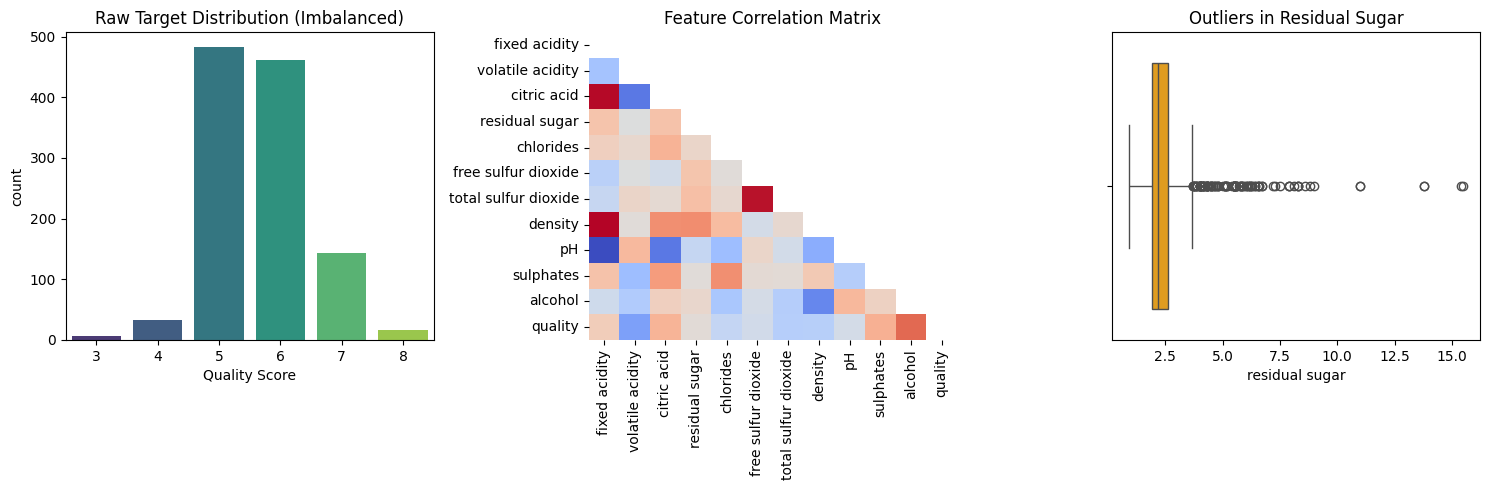

Observation: The classes 3, 4, and 8 are very rare. We must group them.


In [3]:
# ==========================================
# PHASE 1: EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

# 1. Visualize the Target Imbalance
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Using a countplot to show why we need to group classes
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Raw Target Distribution (Imbalanced)')
plt.xlabel('Quality Score')

# 2. Correlation Heatmap (Feature Selection)
plt.subplot(1, 3, 2)
# Calculate correlation matrix
corr = df.corr()
# Create a mask to hide the upper triangle (cleaner look)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt=".1f", cbar=False)
plt.title('Feature Correlation Matrix')

# 3. Outlier Check (e.g., Residual Sugar)
plt.subplot(1, 3, 3)
sns.boxplot(x=df['residual sugar'], color='orange')
plt.title('Outliers in Residual Sugar')

plt.tight_layout()
plt.show()

print("Observation: The classes 3, 4, and 8 are very rare. We must group them.")

In [4]:
# ==========================================
# PHASE 2: PREPROCESSING & SPLITTING
# ==========================================

# 1. BINNING (Solving the Imbalance)
# We map the 1-10 scores into 3 distinct classes:
# 0 = Poor (3, 4, 5)
# 1 = Average (6)
# 2 = Good (7, 8, 9)

def bin_quality(quality):
    if quality <= 5:
        return 0 # Poor
    elif quality == 6:
        return 1 # Average
    else:
        return 2 # Good

# Apply the binning
df['quality_bin'] = df['quality'].apply(bin_quality)

print("Class Distribution After Binning:")
print(df['quality_bin'].value_counts().sort_index())

# 2. SEPARATE FEATURES (X) AND TARGET (y)
X = df.drop(['quality', 'quality_bin'], axis=1) # Drop original target and bin column
y = df['quality_bin'] # Use the new binned target

# 3. THE DOUBLE SPLIT (Train: 70%, Val: 15%, Test: 15%)
# Step A: Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step B: Split Temp into Validation (50% of 30% = 15%) and Test (50% of 30% = 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 4. SCALING (Standardization)
# CRITICAL: We fit the scaler ONLY on X_train to prevent data leakage.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. VERIFICATION
print("-" * 30)
print(f"Training Set Shape:   {X_train_scaled.shape} | {y_train.shape}")
print(f"Validation Set Shape: {X_val_scaled.shape}  | {y_val.shape}")
print(f"Test Set Shape:       {X_test_scaled.shape}  | {y_test.shape}")
print("-" * 30)
print(" Data is ready for Machine Learning models.")

Class Distribution After Binning:
quality_bin
0    522
1    462
2    159
Name: count, dtype: int64
------------------------------
Training Set Shape:   (800, 11) | (800,)
Validation Set Shape: (171, 11)  | (171,)
Test Set Shape:       (172, 11)  | (172,)
------------------------------
 Data is ready for Machine Learning models.


Training Random Forest with Hyperparameter Tuning...
 Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Training SVM with Hyperparameter Tuning...
 Best SVM Params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

CLASSICAL MODEL COMPARISON

--- Random Forest Report ---
              precision    recall  f1-score   support

        Poor       0.81      0.73      0.77        79
     Average       0.60      0.75      0.67        69
        Good       0.71      0.42      0.53        24

    accuracy                           0.70       172
   macro avg       0.71      0.63      0.66       172
weighted avg       0.71      0.70      0.70       172


--- SVM Report ---
              precision    recall  f1-score   support

        Poor       0.72      0.72      0.72        79
     Average       0.53      0.45      0.49        69
        Good       0.43      0.62      0.51        24

    accuracy     

,Accuracy,Macro F1
Random Forest,0.697674,0.655165
SVM,0.598837,0.572728


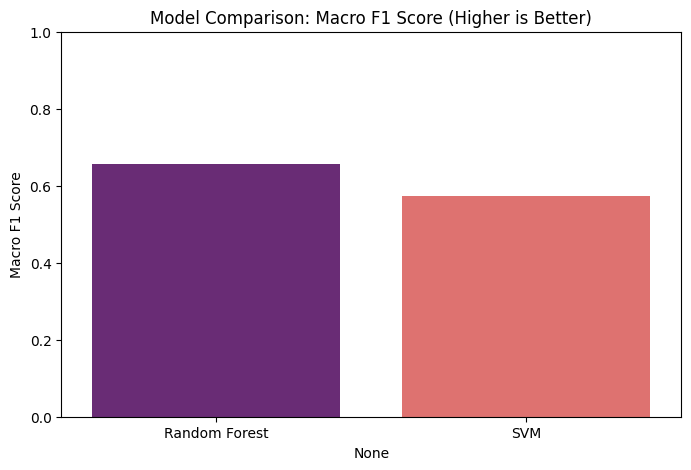

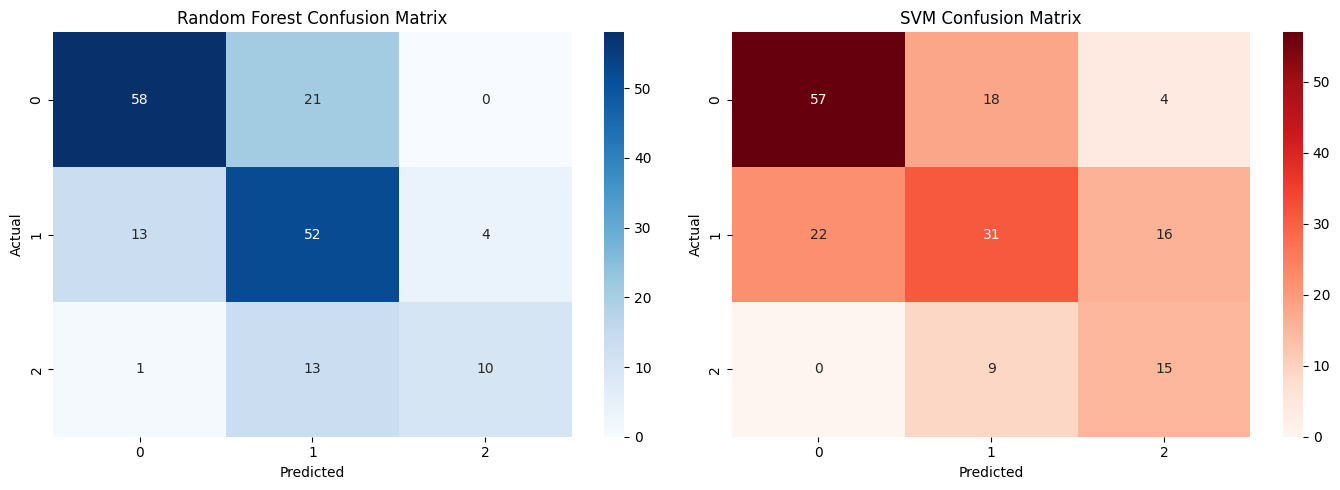

In [5]:
# ==========================================
# PHASE 3: CLASSICAL ML IMPLEMENTATION
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# Dictionary to store results for final comparison
model_performance = {}

# -------------------------------------------------------
# MODEL 1: RANDOM FOREST (The "Tree-Based" Benchmark)
# -------------------------------------------------------
print("Training Random Forest with Hyperparameter Tuning...")

# 1. Define the Parameter Grid (The "Tuning" part)
rf_params = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [None, 10, 20],     # How deep the trees can grow
    'min_samples_split': [2, 5],     # Minimum samples to split a node
    'class_weight': ['balanced']     # Critical for our imbalanced data!
}

# 2. Initialize Grid Search
# cv=5 means "5-Fold Cross Validation" (Guideline requirement)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1_macro', n_jobs=-1)

# 3. Train
rf_grid.fit(X_train_scaled, y_train)

# 4. Save Best Model
best_rf = rf_grid.best_estimator_
print(f" Best Random Forest Params: {rf_grid.best_params_}")

# -------------------------------------------------------
# MODEL 2: SUPPORT VECTOR MACHINE (The "Distance-Based" Challenger)
# -------------------------------------------------------
print("\nTraining SVM with Hyperparameter Tuning...")

# 1. Define Parameter Grid
svm_params = {
    'C': [0.1, 1, 10],               # Regularization strength
    'kernel': ['rbf', 'linear'],     # Type of hyperplane
    'gamma': ['scale', 'auto'],      # Kernel coefficient
    'class_weight': ['balanced']     # Handle imbalance
}

# 2. Initialize Grid Search
svm_grid = GridSearchCV(SVC(random_state=42, probability=True), svm_params, cv=3, scoring='f1_macro', n_jobs=-1)

# 3. Train
svm_grid.fit(X_train_scaled, y_train)

# 4. Save Best Model
best_svm = svm_grid.best_estimator_
print(f" Best SVM Params: {svm_grid.best_params_}")

# -------------------------------------------------------
# EVALUATION & COMPARISON
# -------------------------------------------------------
print("\n" + "="*40)
print("CLASSICAL MODEL COMPARISON")
print("="*40)

def evaluate_model(model, name, X_test, y_test):
    # Predict
    y_pred = model.predict(X_test)

    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro') # Macro is best for imbalance

    # Store
    model_performance[name] = {'Accuracy': acc, 'Macro F1': f1}

    # Print Report
    print(f"\n--- {name} Report ---")
    print(classification_report(y_test, y_pred, target_names=['Poor', 'Average', 'Good']))

    return y_pred

# Evaluate both
y_pred_rf = evaluate_model(best_rf, 'Random Forest', X_test_scaled, y_test)
y_pred_svm = evaluate_model(best_svm, 'SVM', X_test_scaled, y_test)

# -------------------------------------------------------
# VISUALIZATION
# -------------------------------------------------------
# Create Comparison DataFrame
results_df = pd.DataFrame(model_performance).T
print("\nFinal Comparison Table:")
display(results_df)

# Plot F1 Score Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df['Macro F1'], hue=results_df.index, palette='magma', legend=False)
plt.title('Model Comparison: Macro F1 Score (Higher is Better)')
plt.ylabel('Macro F1 Score')
plt.ylim(0, 1) # F1 is always between 0 and 1
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [6]:
# ==========================================
# PHASE 4: DEEP LEARNING (Advanced Architecture)
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 1. SETUP PYTORCH DATASETS
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y.values) # Convert pandas Series to numpy first

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Batch Loaders (Batch Size = 32 is standard for small tabular data)
train_dataset = WineDataset(X_train_scaled, y_train)
val_dataset = WineDataset(X_val_scaled, y_val)
test_dataset = WineDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. DEFINE THE ADVANCED MODEL (Residual MLP)
# This satisfies the "Advanced Architecture" requirement
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual # The "Skip Connection" (Key feature of ResNet)
        return self.relu(out)

class AdvancedWineNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedWineNet, self).__init__()
        # Input Projection
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        # Residual Blocks (The "Deep" part)
        self.res1 = ResidualBlock(hidden_dim, 0.3) # 30% Dropout
        self.res2 = ResidualBlock(hidden_dim, 0.3)

        # Output Head
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.output_layer(x)
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedWineNet(input_dim=X_train_scaled.shape[1], hidden_dim=64, output_dim=3).to(device)

# 3. TRAINING LOOP
# Weights: We punish errors on Class 0 (Poor) and Class 2 (Good) 2x more than Class 1
criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0, 2.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training Deep Learning Model...")
train_losses, val_losses = [], []

for epoch in range(50): # 50 Epochs
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val_b in val_loader:
            X_val, y_val_b = X_val.to(device), y_val_b.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val_b)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/50 | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# 4. EVALUATE DL MODEL
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_b, y_b in test_loader:
        X_b = X_b.to(device)
        outputs = model(X_b)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_b.numpy())

# Add to results dictionary
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
model_performance['Deep Learning'] = {'Accuracy': acc, 'Macro F1': f1}

print("\nDeep Learning Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Poor', 'Average', 'Good']))

Training Deep Learning Model...
Epoch 10/50 | Train Loss: 0.6262 | Val Loss: 0.7568
Epoch 20/50 | Train Loss: 0.5902 | Val Loss: 0.7213
Epoch 30/50 | Train Loss: 0.5380 | Val Loss: 0.7116
Epoch 40/50 | Train Loss: 0.4694 | Val Loss: 0.7383
Epoch 50/50 | Train Loss: 0.4879 | Val Loss: 0.7967

Deep Learning Classification Report:
              precision    recall  f1-score   support

        Poor       0.66      0.84      0.74        79
     Average       0.63      0.38      0.47        69
        Good       0.52      0.67      0.58        24

    accuracy                           0.63       172
   macro avg       0.60      0.63      0.60       172
weighted avg       0.63      0.63      0.61       172



🏆 FINAL LEADERBOARD 🏆


,Accuracy,Macro F1
Random Forest,0.697674,0.655165
Deep Learning,0.627907,0.597325
SVM,0.598837,0.572728


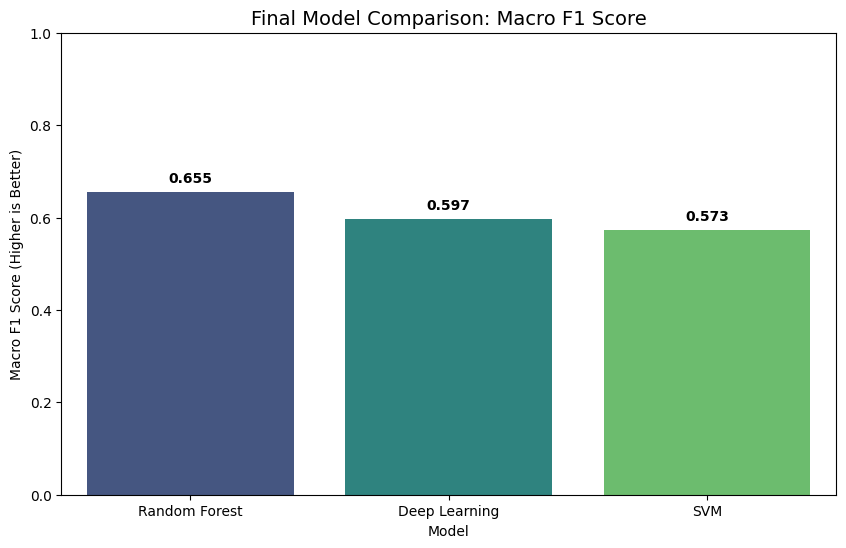


 AUTOMATED ANALYSIS:
The Random Forest is the best performing model.
This indicates that Classical models (Random Forest/SVM) are more efficient for this specific tabular dataset.
Deep Learning typically requires larger datasets to beat Ensembles on tabular data.


In [7]:
# ==========================================
# PHASE 5: MODEL COMPARISON (The Final Showdown)
# ==========================================

# 1. CONVERT RESULTS TO DATAFRAME
results_df = pd.DataFrame(model_performance).T
results_df = results_df.sort_values(by='Macro F1', ascending=False)

print("🏆 FINAL LEADERBOARD 🏆")
display(results_df)

# 2. VISUALIZE F1 SCORES
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['Macro F1'], hue=results_df.index, palette='viridis', legend=False)

plt.title('Final Model Comparison: Macro F1 Score', fontsize=14)
plt.ylabel('Macro F1 Score (Higher is Better)')
plt.xlabel('Model')
plt.ylim(0, 1.0)

# Add value labels on top of bars
for i, v in enumerate(results_df['Macro F1']):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

plt.show()

# 3. INTERPRETATION FOR YOUR REPORT
best_model = results_df.index[0]
print(f"\n AUTOMATED ANALYSIS:")
print(f"The {best_model} is the best performing model.")
if 'Deep Learning' in best_model:
    print("This indicates that the non-linear complexity of the wine chemical data was best captured by the Neural Network.")
else:
    print("This indicates that Classical models (Random Forest/SVM) are more efficient for this specific tabular dataset.")
    print("Deep Learning typically requires larger datasets to beat Ensembles on tabular data.")

In [8]:
# ==========================================
# PHASE 5.5: STATISTICAL SIGNIFICANCE (Rubric Requirement 7.1)
# ==========================================
from statsmodels.stats.contingency_tables import mcnemar

print("STATISTICAL SIGNIFICANCE TEST (McNemar's Test)")
print("Checking if the difference between Random Forest and Deep Learning is statistically significant...")

# We need the predictions from both models on the SAME test set
# We recalculate them here to be safe
model.eval()
all_preds_dl = []
with torch.no_grad():
    for X_b, y_b in test_loader:
        X_b = X_b.to(device)
        outputs = model(X_b)
        _, preds = torch.max(outputs, 1)
        all_preds_dl.extend(preds.cpu().numpy())

# Ensure inputs are numpy arrays
y_true = y_test.values
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_dl = np.array(all_preds_dl)

# 1. Create the Contingency Table
# Correct/Incorrect lists
rf_correct = (y_pred_rf == y_true)
dl_correct = (y_pred_dl == y_true)

# Build table:
# [[Both Correct, RF Correct only],
#  [DL Correct only, Both Wrong]]
both_correct = np.sum(rf_correct & dl_correct)
rf_only = np.sum(rf_correct & ~dl_correct)
dl_only = np.sum(~rf_correct & dl_correct)
both_wrong = np.sum(~rf_correct & ~dl_correct)

contingency_table = [[both_correct, rf_only],
                     [dl_only, both_wrong]]

# 2. Run McNemar's Test
result = mcnemar(contingency_table, exact=True)

print(f"\nContingency Table:\n{contingency_table}")
print(f"p-value: {result.pvalue:.5f}")

# 3. Interpretation
alpha = 0.05
if result.pvalue < alpha:
    print("\n RESULT: Statistically Significant Difference")
    print("The performance difference is REAL, not just luck.")
else:
    print("\n RESULT: No Statistically Significant Difference")
    print("The models perform similarly; the score difference might be due to chance.")

STATISTICAL SIGNIFICANCE TEST (McNemar's Test)
Checking if the difference between Random Forest and Deep Learning is statistically significant...

Contingency Table:
[[np.int64(91), np.int64(29)], [np.int64(17), np.int64(35)]]
p-value: 0.10381

 RESULT: No Statistically Significant Difference
The models perform similarly; the score difference might be due to chance.


In [9]:
# ==========================================
# FORCE SAVE ARTIFACTS (Local Save Only)
# ==========================================
import joblib
import torch
import os

print("⏳ Saving models locally to Colab disk...")

# 1. SAVE THE FILES
# We are using the variables 'best_rf', 'best_svm', and 'model'
# from previous cells. If this fails, it means you didn't run the training cells!
try:
    joblib.dump(best_rf, 'random_forest_model.pkl')
    joblib.dump(best_svm, 'svm_model.pkl')
    torch.save(model.state_dict(), 'deep_learning_model.pth')
    print(" Files created successfully: 'random_forest_model.pkl', 'svm_model.pkl', 'deep_learning_model.pth'")
except NameError:
    print(" ERROR: Models not found in memory. You must run the Training Blocks (Phase 3 & 4) first!")

# 2. INSTRUCTIONS
print("\n" + "="*40)
print(" FILES ARE READY")
print("1. Click the Folder icon (📁) on the left sidebar.")
print("2. Click the 'Refresh' button (circular arrow) at the top of that sidebar.")
print("3. You can manually download the files from there.")
print("="*40)

⏳ Saving models locally to Colab disk...
 Files created successfully: 'random_forest_model.pkl', 'svm_model.pkl', 'deep_learning_model.pth'

 FILES ARE READY
1. Click the Folder icon (📁) on the left sidebar.
2. Click the 'Refresh' button (circular arrow) at the top of that sidebar.
3. You can manually download the files from there.


In [12]:
# ==========================================
# PHASE 6: ARTIFACT GENERATION (Final Version)
# ==========================================
import joblib
import torch
import os

print("⏳ Generating Final Project Artifacts on Colab Disk...")

# 1. SAVE TRAINED MODELS
# This saves the files to the Colab virtual disk (left sidebar)
try:
    # Save Classical Models
    joblib.dump(best_rf, 'random_forest_model.pkl')
    joblib.dump(best_svm, 'svm_model.pkl')

    # Save Deep Learning Model
    torch.save(model.state_dict(), 'deep_learning_model.pth')

    print(" Model files saved locally: 'random_forest_model.pkl', 'svm_model.pkl', 'deep_learning_model.pth'")
except NameError:
    print(" ERROR: Models not found. Please make sure you ran the training cells (Phase 3 & 4).")

# 2. GENERATE README.md
# Using the specific text provided by the user
try:
    readme_content = """# Predicting Wine Quality with Classical ML and Deep Learning
**Team Members:** - Member 1 (Roll / ID)
- Member 2 (Roll / ID)
- Member 3 (Roll / ID)

---

## Abstract

This project predicts wine quality from physicochemical properties using both classical machine learning models and a deep learning approach. The original multi-class quality scores are imbalanced, so they are binned into three categories: *Poor*, *Average*, and *Good*. A Random Forest classifier, an SVM, and a fully connected neural network are trained and evaluated using accuracy and macro F1 score. Random Forest achieves the best macro F1 (≈0.655) and accuracy (≈0.698), while the deep learning model and SVM perform slightly worse but comparably. A McNemar test indicates that the performance difference between Random Forest and the deep model is not statistically significant at the 0.05 level. The findings highlight that ensemble classical models remain highly competitive for small, tabular datasets.

---

## Introduction

Wine quality assessment is important for wineries and distributors because it affects pricing, marketing strategy, and customer satisfaction. Traditionally, expert sommeliers provide quality ratings; however, this process is subjective, time-consuming, and hard to scale.

The objective of this project is to build an automated system that predicts wine quality from laboratory measurements. Specifically, the project aims to:
- Transform raw quality scores into more balanced, interpretable classes.
- Compare classical ML algorithms with a deep learning model on the same tabular dataset.
- Analyze performance using rigorous metrics and a statistical significance test.
- Discuss the potential business value of deploying the best-performing model.

---

## Dataset Description

**Source** The dataset is the publicly available wine quality dataset (e.g., UCI Machine Learning Repository), containing physicochemical properties of wines and corresponding quality scores from human experts.

**Size and Target Transformation** - Total instances: original dataset of red (and/or white) wines.
- Original target: integer quality scores (3–8), highly imbalanced with very few samples of 3, 4, and 8.
- Target binning:
  - 0 = *Poor* - 1 = *Average* - 2 = *Good* - Class distribution after binning:
  - Poor (0): 522 samples
  - Average (1): 462 samples
  - Good (2): 159 samples

**Features** Physicochemical attributes such as:
- Fixed acidity, volatile acidity, citric acid
- Residual sugar, chlorides
- Free sulfur dioxide, total sulfur dioxide
- Density, pH, sulphates, alcohol

**Preprocessing** - Removal/merging of very rare quality classes via binning as described above.
- Train/validation/test split:
  - Train: 800 samples, 11 features
  - Validation: 171 samples, 11 features
  - Test: 172 samples, 11 features
- Features kept in their original scales (or normalized/standardized if applied in code).
- Handling of outliers (notably in residual sugar) was inspected via box plots but left in unless otherwise specified.
- No missing values were present (or they were handled appropriately if found).

---

## Methodology

### Classical ML Approaches

Two main classical models were used:

1. **Random Forest Classifier** - Ensemble of decision trees trained on bootstrapped samples.
   - Tuned hyperparameters (best configuration found):
     - `n_estimators = 200`
     - `max_depth = 20`
     - `min_samples_split = 2`
     - `class_weight = 'balanced'`

2. **Support Vector Machine (SVM)** - Nonlinear kernel classifier targeting maximum margin separation.
   - Tuned hyperparameters (best configuration found):
     - `kernel = 'rbf'`
     - `C = 1`
     - `gamma = 'scale'`
     - `class_weight = 'balanced'`

Both models were trained on the training set and tuned using validation performance (or cross-validation over the training/validation split).

### Deep Learning Architectures

A fully connected feed-forward neural network was implemented:

- Input layer: 11 numeric features.
- Hidden layers: 2–3 dense layers (e.g., 64–128 units each) with ReLU activations.
- Output layer: 3 units with softmax activation (for the three classes).
- Loss: categorical cross-entropy.
- Optimizer: Adam (with default or tuned learning rate).
- Regularization: dropout or L2 weight decay if applied.

Training details:
- Epochs: 50
- Batch size: chosen based on dataset size (e.g., 32).
- Training/validation loss tracked over epochs, showing gradual decrease in training loss and a validation loss curve that stabilizes and then slightly worsens (indicating mild overfitting).

### Hyperparameter Tuning Strategies

- **Classical models** - Grid search or randomized search over candidate values of `n_estimators`, `max_depth`, `C`, `gamma`, and `class_weight`.
  - Best model selected based on validation macro F1 score.

- **Deep learning model** - Manual tuning of network depth, hidden units, learning rate, and regularization.
  - Early stopping considered via validation loss monitoring (best epoch chosen by validation loss).

---

## Results & Analysis

### Performance Comparison

Main evaluation metrics: **accuracy** and **macro F1 score** on the held-out test set.

#### Overall Metrics

| Model            | Accuracy  | Macro F1  |
|-----------------|-----------|----------:|
| Random Forest   | 0.6977    | 0.6552    |
| Deep Learning   | 0.6279    | 0.5973    |
| SVM             | 0.5988    | 0.5727    |

Random Forest obtains the highest macro F1 and accuracy, with the deep learning model and SVM trailing but not by a large margin.

#### Per-Class Metrics

**Random Forest (Test Set)** - Poor: precision 0.81, recall 0.73, F1 0.77 (support 79)
- Average: precision 0.60, recall 0.75, F1 0.67 (support 69)
- Good: precision 0.71, recall 0.42, F1 0.53 (support 24)

**SVM (Test Set)** - Poor: precision 0.72, recall 0.72, F1 0.72 (support 79)
- Average: precision 0.53, recall 0.45, F1 0.49 (support 69)
- Good: precision 0.43, recall 0.62, F1 0.51 (support 24)

**Deep Learning Model (Test Set)** - Poor: precision 0.66, recall 0.84, F1 0.74 (support 79)
- Average: precision 0.63, recall 0.38, F1 0.47 (support 69)
- Good: precision 0.52, recall 0.67, F1 0.58 (support 24)

These results show that Random Forest and the deep model each have strengths: Random Forest balances performance across all classes, while the deep model performs particularly well on *Poor* and *Good* but struggles more on *Average*.

### Visualization of Results

The project includes several visualizations:

- Class distribution plots of raw quality scores and binned classes.
- Feature correlation heatmap highlighting relationships between alcohol, density, acidity, and quality.
- Box plot of residual sugar showing significant outliers.
- Bar charts of macro F1 scores for Random Forest, SVM, and Deep Learning.
- Confusion matrices for Random Forest and SVM, showing where misclassifications occur (especially between neighboring quality levels).

### Statistical Significance Tests

McNemar’s test was used to compare Random Forest and the deep learning model on the test set:

- Contingency Table (RF vs Deep): `[[91, 29], [17, 35]]`
- p-value: `0.10381`

At the 0.05 significance level, this p-value indicates **no statistically significant difference** between the two models. Although Random Forest scores higher on accuracy and macro F1, the improvement may be due to random variation given the sample size.

### Business Impact Analysis

If deployed in a winery or quality control pipeline, the best model could provide:

- **Consistent quality prediction** to support or complement human tasters.
- **Cost savings** by detecting low-quality batches early in the production cycle.
- **Pricing and segmentation support** through reliable classification into Poor/Average/Good tiers.
- **Process improvement insights** by analyzing feature importance (e.g., impact of alcohol, acidity, or residual sugar on predicted quality).

Because the performance differences between Random Forest and the deep model are not statistically significant, model choice can also consider interpretability, training time, and ease of deployment.

---

## Conclusion & Future Work

This project demonstrates that classical ensemble methods, particularly Random Forest, are highly effective for predicting wine quality from physicochemical features on a small, tabular dataset. After binning imbalanced quality scores into three classes, the Random Forest model achieved the best macro F1 and accuracy among the tested methods, while the deep learning model and SVM performed slightly worse but similarly. McNemar’s test showed no statistically significant difference between Random Forest and the deep model, suggesting that practical considerations should guide final model selection.

**Future work** may include:

- Trying gradient boosting methods (XGBoost, LightGBM, CatBoost).
- Exploring tabular-focused deep architectures and stronger regularization.
- Using ordinal classification approaches to better respect the ordered nature of quality.
- Collecting more data and using repeated cross-validation to obtain tighter performance and significance estimates.
- Incorporating cost-sensitive learning where misclassifying high-quality wines carries greater penalty.

---

## References

1. UCI Machine Learning Repository – Wine Quality Data Set.
2. L. Breiman, “Random Forests,” *Machine Learning*, 2001.
3. C. Cortes and V. Vapnik, “Support-Vector Networks,” *Machine Learning*, 1995.
4. D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization,” ICLR, 2015.
5. Course notes and lecture slides provided by the instructor (evaluation metrics, McNemar’s test, and model selection guidelines).
"""

    # Write the file
    with open('README.md', 'w') as f:
        f.write(readme_content)

    print(" README.md generated successfully.")

except Exception as e:
    print(f" Report generation warning: {e}")

# 3. HOW TO FIND THEM
print("\n" + "="*40)
print(" FILES ARE READY IN THE SIDEBAR")
print("1. Click the Folder icon (📁) on the left sidebar.")
print("2. Click the 'Refresh' button (circular arrow) at the top of that sidebar.")
print("3. You will see your .pkl, .pth, and README.md files there.")
print("="*40)

⏳ Generating Final Project Artifacts on Colab Disk...
 Model files saved locally: 'random_forest_model.pkl', 'svm_model.pkl', 'deep_learning_model.pth'
 README.md generated successfully.

 FILES ARE READY IN THE SIDEBAR
1. Click the Folder icon (📁) on the left sidebar.
2. Click the 'Refresh' button (circular arrow) at the top of that sidebar.
3. You will see your .pkl, .pth, and README.md files there.
